In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.loadtxt('../support/zipcombo.dat')
# data = np.loadtxt('../support/dtrain123.dat')

In [3]:
data.shape

(9298, 257)

In [4]:
def split_80_20(data: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Splits 80% train 20% test

    :param data: sequence.
    :return: train_data, test_data: np.ndarray, np.ndarray
    """

    n = data.shape[0]
    train_size = int(n*0.8)
    return data[:train_size], data[train_size:]

In [5]:
def split_X_y(data: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Splits the data into datapoints and labels, X_train matrix and y_train;
    :param data: np.ndarray
    :return: X_train, y_train: np.ndarray, np.ndarray
    """

    return data[:, 1:], data[:, 0]

In [6]:
def shuffle_split(data):
    # np.random.seed(seed)
    shuffled = np.random.permutation(data)
    data_train, data_test = split_80_20(shuffled)
    X_train, y_train = split_X_y(data_train)
    X_test, y_test = split_X_y(data_test)

    assert X_train.shape[0] == y_train.size
    assert X_test.shape[0] == y_test.size

    print("Train data set size = %d" % X_train.shape[0])
    print("Test data set size = %d" % X_test.shape[0])

    return X_train, y_train, X_test, y_test

In [7]:
def get_error_percentage(y, y_preds):
    error = 100 * get_num_mistakes(actual=y, predicted=y_preds) / y.size
    # print("in-sample = % " + str(error))
    return error

def get_num_mistakes(actual: np.ndarray, predicted: np.ndarray) -> int:
    # or calculating by checking which alpha values are different than 0? alpha is 0 when the prediction matches
    diffs = actual - predicted
    n_mistakes = 0
    for diff in diffs:
        if diff != 0:
            n_mistakes += 1
    return n_mistakes

In [8]:
X_train, y_train, X_test, y_test = shuffle_split(data)

Train data set size = 7438
Test data set size = 1860


In [9]:
class KPOneVsAllClassifier:
    def __init__(self, n_classes, c):
        self.n_classes = n_classes # could optimize to remove this var since =k.shape[0]
        self.c = c
        self.X_train = None
        self.Alpha = None
        self.K = None

    def _get_kernel_matrix(self, X_train: np.ndarray) -> np.ndarray:
        ## we use ||x-y|| = np.inner(x-y, x-y)
        ## and ||x-y||^2 = ||x||^2 + ||y||^2 - 2*x.T*y
        X_norm = np.einsum('ij,ij->i', X_train, X_train)
        return np.exp((-self.c) * (X_norm[:, None] + X_norm[None, :] - 2*np.dot(X_train, X_train.T)))

    def _get_kernel_matrix_predict(self, X_train: np.ndarray, X_test: np.ndarray) -> np.ndarray:
        ## we use ||x-y|| = np.inner(x-y, x-y)
        ## and ||x-y||^2 = ||x||^2 + ||y||^2 - 2*x.T*y
        X_test_norm = np.linalg.norm(X_test, axis=1, keepdims=False)
        X_train_norm = np.linalg.norm(X_train, axis=1, keepdims=False)
        return np.exp(-self.c * (X_test_norm[:, None] + X_train_norm[None, :] - 2 * X_test @ X_train.T))

    def sign(self, x: np.ndarray) -> np.ndarray:
        return np.where(x <= 0, -1, 1)

    def _predict_single_confidence(self, t, y_train):
        # Get prediction array P
        # preds = (self.Alpha @ self.K)[:, t]
        preds = self.Alpha @ self.K[t]

        # Get Y_t array of ground truth (duplicate y_t)
        y = np.full(self.n_classes, -1)
        y[int(y_train[t])] = 1

        # penilize
        self.Alpha[:, t] -= np.heaviside(-(preds * y), 1) * self.sign(preds)
        return preds


    def fit(self, X_train, y_train, n_epochs):
        y_preds = np.array(np.zeros(X_train.shape[0]))

        self.K = self._get_kernel_matrix(X_train)
        self.Alpha = np.zeros((self.n_classes, X_train.shape[0]))
        self.X_train = X_train

        for epoch in range(n_epochs):
            # for each point, calculate confidence and make predictions
            for t in range(0, X_train.shape[0]):
                confidence = self._predict_single_confidence(t, y_train)
                # the index with the highest number(confidence) is the prediction
                # +1 because the index for confidence in perceptron[1] is 0
                y_preds[t] = np.argmax(confidence)
        return y_preds

    def predict(self, X_test: np.ndarray):
        self.K_test = self._get_kernel_matrix_predict(self.X_train, X_test)
        return np.argmax((self.Alpha @ self.K_test.T), axis=0)

## for in-cell debug
import time

# start = time.time()
#
# kpova = KPOneVsAllClassifier(n_classes=10, c=0.01)
# kpova.fit(X_train, y_train, n_epochs=7)
# y_insample = kpova.predict(X_train)
# y_outsample = kpova.predict(X_test)
#
# end = time.time()
#
# print("took :{t}".format(t=end-start))
#
# print(get_error_percentage(y_train, y_insample))
# print(get_error_percentage(y_test, y_outsample))

took :5.841084957122803
4.503898897553106
7.258064516129032


### Repeat 1 and 2
- do the parameter tuning c
- first, do some experiments to decide the values to cross_validate over for c
- since gamma, i.e. $c$ is not as sensible as $d$ is in polynomial kernel, we make a with multiples of 10. Practice observed use the same approach


#### First, we run the 1.basic results algorithm to get an intuition of how $c$ impacts the errors, so that we can find out on which $S$ to cross validate. We set n_epochs=7

In [10]:
import time

means_train = []
means_test = []
stds_train = []
stds_test = []

c_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10]

start=time.time()
for c in c_vals:
    train_errors = []
    test_errors = []
    for run in range(20):
        X_train, y_train, X_test, y_test = shuffle_split(data)

        kpova = KPOneVsAllClassifier(n_classes=10, c=c)

        #train
        kpova.fit(X_train, y_train, n_epochs=7)
        y_insample = kpova.predict(X_train)
        #test
        y_outsample = kpova.predict(X_test)

        print('\nd=' + str(c) + ' on run ' + str(run))
        train_errors.append(get_error_percentage(y_train, y_insample))
        test_errors.append(get_error_percentage(y_test, y_outsample))
    means_train.append(np.mean(train_errors))
    means_test.append(np.mean(test_errors))
    stds_train.append(np.std(train_errors))
    stds_test.append(np.std(test_errors))
end = time.time()

print('took {t}'.format(t=end-start))

Train data set size = 7438
Test data set size = 1860

d=0.0001 on run 0
Train data set size = 7438
Test data set size = 1860

d=0.0001 on run 1
Train data set size = 7438
Test data set size = 1860

d=0.0001 on run 2
Train data set size = 7438
Test data set size = 1860

d=0.0001 on run 3
Train data set size = 7438
Test data set size = 1860

d=0.0001 on run 4
Train data set size = 7438
Test data set size = 1860

d=0.0001 on run 5
Train data set size = 7438
Test data set size = 1860

d=0.0001 on run 6
Train data set size = 7438
Test data set size = 1860

d=0.0001 on run 7
Train data set size = 7438
Test data set size = 1860

d=0.0001 on run 8
Train data set size = 7438
Test data set size = 1860

d=0.0001 on run 9
Train data set size = 7438
Test data set size = 1860

d=0.0001 on run 10
Train data set size = 7438
Test data set size = 1860

d=0.0001 on run 11
Train data set size = 7438
Test data set size = 1860

d=0.0001 on run 12
Train data set size = 7438
Test data set size = 1860

d=0.000

C:\Users\Andrei\AppData\Local\Temp\ipykernel_20364\433788266.py:20: RuntimeWarning: overflow encountered in exp
  return np.exp(-self.c * (X_test_norm[:, None] + X_train_norm[None, :] - 2 * X_test @ X_train.T))
C:\Users\Andrei\AppData\Local\Temp\ipykernel_20364\433788266.py:57: RuntimeWarning: invalid value encountered in matmul
  return np.argmax((self.Alpha @ self.K_test.T), axis=0)



d=10 on run 0
Train data set size = 7438
Test data set size = 1860

d=10 on run 1
Train data set size = 7438
Test data set size = 1860

d=10 on run 2
Train data set size = 7438
Test data set size = 1860

d=10 on run 3
Train data set size = 7438
Test data set size = 1860

d=10 on run 4
Train data set size = 7438
Test data set size = 1860

d=10 on run 5
Train data set size = 7438
Test data set size = 1860

d=10 on run 6
Train data set size = 7438
Test data set size = 1860

d=10 on run 7
Train data set size = 7438
Test data set size = 1860

d=10 on run 8
Train data set size = 7438
Test data set size = 1860

d=10 on run 9
Train data set size = 7438
Test data set size = 1860

d=10 on run 10
Train data set size = 7438
Test data set size = 1860

d=10 on run 11
Train data set size = 7438
Test data set size = 1860

d=10 on run 12
Train data set size = 7438
Test data set size = 1860

d=10 on run 13
Train data set size = 7438
Test data set size = 1860

d=10 on run 14
Train data set size = 7438
T

In [11]:
import pandas as pd

table_1a = pd.DataFrame({
    'c': c_vals,
    'mean train': [str(f'{x:.3f}') + u"\u00B1" + str(f'{y:.3f}') for (x, y) in zip(means_train, stds_train)],
    'mean test': [str(f'{x:.3f}') + u"\u00B1" + str(f'{y:.3f}') for (x, y) in zip(means_test, stds_test)],
})

display(table_1a)
table_1a.to_csv('results_gaussian/table_1a.csv')
table_1a.style.to_latex('results_gaussian/table_1a.tex')

,c,mean train,mean test
0,0.0001,18.777±5.777,19.363±5.376
1,0.0010,38.758±5.874,39.957±6.475
2,0.0100,13.680±1.751,17.239±1.632
3,0.1000,1.583±0.189,7.185±0.520
4,1.0000,2.135±0.199,8.470±0.785
5,10.0000,83.295±0.158,83.306±0.632


### Now we have to decide S, the range to cross validate over parameter c

we can conclude empirically that the range would be between (0.100, 1.000)

In [21]:
def cross_validation(X, y, n_folds):
    fold_size = X.shape[0] // n_folds

    split_idxs = [i * fold_size - 1 for i in range(1, 5)]
    X_folds_list = np.split(X, indices_or_sections=split_idxs)
    y_folds_list = np.split(y, indices_or_sections=split_idxs)
    assert len(X_folds_list) == len(y_folds_list) == n_folds
    new_c_vals = [0.100, 0.150, 0.200, 0.500, 1.000]

    errors_d = []
    ### BE CAREFUL AT THE OFFSET
    for c in new_c_vals:
        local_errors = []
        for i in range(n_folds):
            # Create a training and test folds from given data
            X_train_fold = np.vstack(([X_folds_list[k] for k in range(0, n_folds) if k != i]))
            y_train_fold = np.concatenate([y_folds_list[k] for k in range(0, n_folds) if k != i], axis=0)
            X_validation_fold = X_folds_list[i]
            y_validation_fold = y_folds_list[i]

            kp = KPOneVsAllClassifier(n_classes=10, c=c)
            kp.fit(X_train_fold, y_train_fold, n_epochs=7)
            y_preds = kp.predict(X_validation_fold)

            # find the hardest points to predict
            train_diffs = y_validation_fold - y_preds
            for pos in np.where(train_diffs!=0):
                mistakes[pos] += 1

            local_errors.append(get_error_percentage(y_validation_fold, y_preds))
        errors_d.append(local_errors)

    return new_c_vals[np.argmax(np.mean(errors_d, axis=1))]

In [16]:
# calculate the number of instances of each digit in the dataset
# since we just reshuffle, the number holds for cross validation as well
instances = np.array(np.zeros(10, dtype='int'))

for y in y_train:
    instances[int(y)]+=1
for y in y_test:
    instances[int(y)]+=1

instances

array([1553, 1269,  929,  824,  852,  716,  834,  792,  708,  821])

In [22]:
best_ds = []
test_errors = []
confusion_matrix = np.array(np.zeros((10, 10, 20)))
mistakes = np.array(np.zeros(data.shape[0]))

for run in range(20):
    print('\nRUN = '+str(run))
    shuffled = np.random.permutation(data)
    train_data, test_data = split_80_20(shuffled)
    X_train, y_train = split_X_y(train_data)
    X_test, y_test = split_X_y(test_data)

    best_c = cross_validation(X_train, y_train, 5)

    print('\n      Best C = ' + str(best_c))
    kpova = KPOneVsAllClassifier(n_classes=10, c=best_c)
    kpova.fit(X_train, y_train, n_epochs=7)
    y_outsample = kpova.predict(X_test)
    test_error = get_error_percentage(y_test, y_outsample)

    print('\n      Retrain DONE')

    # get errors per digit for CONFUSION MATRIX
    local_conf = np.array(np.zeros((10, 10)))
    for (truth, pred) in zip(y_test, y_outsample):
        if truth!=pred:
            local_conf[int(truth), int(pred)] += 1

    print('\n      Confusion matrix DONE')
    # in local_conf divide each row by instances[row]
    # stack the entire matrix in the third dimension
    confusion_matrix[:, :, run] = local_conf / instances[:, None]

    best_ds.append(best_c)
    test_errors.append(test_error)


RUN = 0

      Best C = 0.5

      Retrain DONE

      Confusion matrix DONE

RUN = 1

      Best C = 0.5

      Retrain DONE

      Confusion matrix DONE

RUN = 2

      Best C = 1.0

      Retrain DONE

      Confusion matrix DONE

RUN = 3

      Best C = 0.5

      Retrain DONE

      Confusion matrix DONE

RUN = 4

      Best C = 1.0

      Retrain DONE

      Confusion matrix DONE

RUN = 5

      Best C = 1.0

      Retrain DONE

      Confusion matrix DONE

RUN = 6

      Best C = 1.0

      Retrain DONE

      Confusion matrix DONE

RUN = 7

      Best C = 0.5

      Retrain DONE

      Confusion matrix DONE

RUN = 8

      Best C = 0.5

      Retrain DONE

      Confusion matrix DONE

RUN = 9

      Best C = 1.0

      Retrain DONE

      Confusion matrix DONE

RUN = 10

      Best C = 1.0

      Retrain DONE

      Confusion matrix DONE

RUN = 11

      Best C = 0.5

      Retrain DONE

      Confusion matrix DONE

RUN = 12

      Best C = 1.0

      Retrain DONE

      Confu

In [23]:
np.savetxt('results_gaussian/mistakes_ova.npy', mistakes)

# point 2 - CROSS VALIDATION
ds_errors = pd.DataFrame({
    'best_ds' : best_ds,
    'test_errors' : test_errors,
})

print(str(f'{np.mean(best_ds):.3f}') + u"\u00B1" + str(f'{np.std(best_ds):.3f}'))
print(str(f'{np.mean(test_errors):.3f}') + u"\u00B1" + str(f'{np.std(test_errors):.3f}'))

ds_errors.to_csv('results_gaussian/best_d_errors.csv')
ds_errors.style.to_latex('results_gaussian/best_d_errors.tex')

0.800±0.245
8.621±0.590


In [24]:
# point 3 - CONFUSION MATRIX

mean_confusion = confusion_matrix.mean(axis=2)*100
std_confusion = confusion_matrix.std(axis=2)*100
mean_std = np.array(np.zeros((10, 10))).astype('U')

for i in range(mean_confusion.shape[0]):
    mean_std[i] = [str(f'{x:.3f}') + u"\u00B1" + str(f'{y:.3f}') for (x, y) in zip(mean_confusion[i], std_confusion[i])]

# save means and stddev separately
pd.DataFrame(mean_confusion).to_csv('results_gaussian/means_confusion.csv')
pd.DataFrame(std_confusion).to_csv('results_gaussian/stddev_confusion.csv')

# save and print the combined matrices
mean_std_df = pd.DataFrame(mean_std)
mean_std_df.to_csv('results_gaussian/confusion_matrix.csv')
mean_std_df.style.to_latex('results_gaussian/confusion_matrix.tex')

mean_std_df

,0,1,2,3,4,5,6,7,8,9
0,0.000±0.000,0.116±0.088,0.080±0.079,0.058±0.061,0.026±0.032,0.074±0.059,0.116±0.085,0.071±0.064,0.013±0.026,0.042±0.047
1,0.020±0.034,0.000±0.000,0.016±0.032,0.012±0.028,0.102±0.134,0.004±0.017,0.039±0.039,0.028±0.045,0.004±0.017,0.000±0.000
2,0.339±0.146,0.441±0.306,0.000±0.000,0.242±0.131,0.221±0.146,0.269±0.130,0.135±0.136,0.662±0.239,0.102±0.110,0.156±0.115
3,0.127±0.124,0.291±0.235,0.285±0.181,0.000±0.000,0.152±0.171,0.734±0.235,0.079±0.088,0.261±0.155,0.121±0.138,0.194±0.201
4,0.317±0.220,0.692±0.290,0.235±0.162,0.141±0.109,0.000±0.000,0.252±0.201,0.258±0.164,0.393±0.281,0.082±0.099,0.446±0.218
5,0.244±0.197,0.384±0.233,0.161±0.167,0.608±0.259,0.154±0.124,0.000±0.000,0.328±0.235,0.279±0.250,0.161±0.167,0.223±0.156
6,0.294±0.229,0.174±0.163,0.126±0.096,0.036±0.086,0.072±0.070,0.120±0.126,0.000±0.000,0.144±0.105,0.030±0.064,0.078±0.109
7,0.032±0.055,0.189±0.189,0.069±0.084,0.025±0.051,0.114±0.112,0.057±0.093,0.057±0.093,0.000±0.000,0.025±0.051,0.095±0.125
8,0.381±0.190,0.537±0.274,0.332±0.254,0.862±0.282,0.332±0.220,0.530±0.223,0.198±0.169,0.459±0.199,0.000±0.000,0.360±0.181
9,0.238±0.194,0.189±0.130,0.085±0.103,0.067±0.090,0.445±0.253,0.085±0.087,0.420±0.284,1.011±0.306,0.049±0.097,0.000±0.000


<AxesSubplot: >

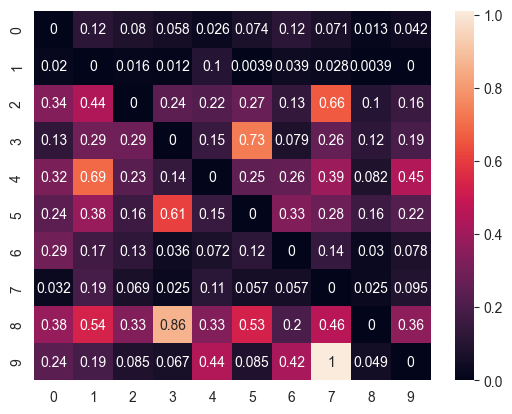

In [25]:
import seaborn as sns
# create confusion matrix heatmap to show more intuitive results
sns.heatmap(mean_confusion, annot=True)

<AxesSubplot: >

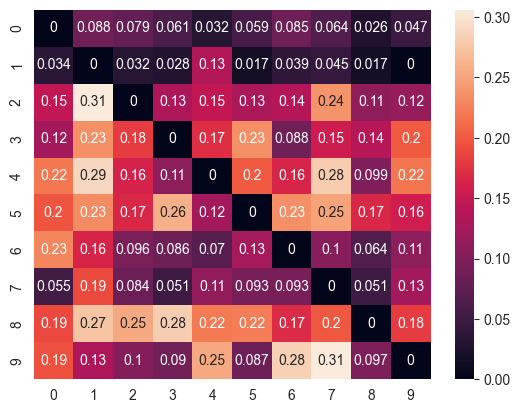

In [26]:
sns.heatmap(std_confusion, annot=True)

In [27]:
def display_digit(grayscale):
    plt.imshow(np.reshape(grayscale, (16, 16)), cmap='gray')
    plt.show()

1.0


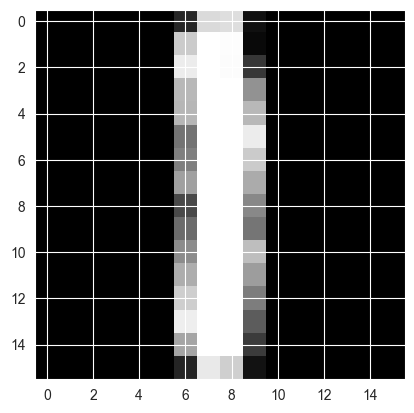



2.0


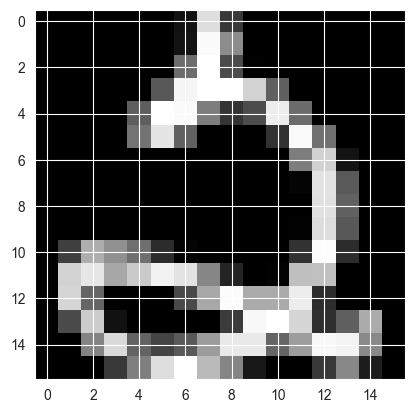



0.0


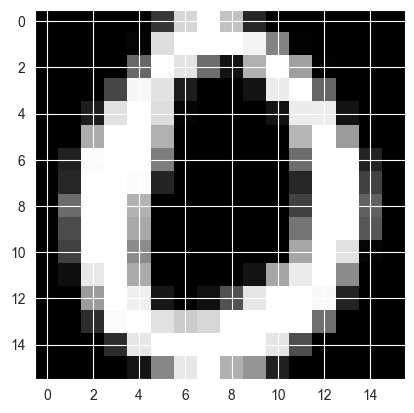



4.0


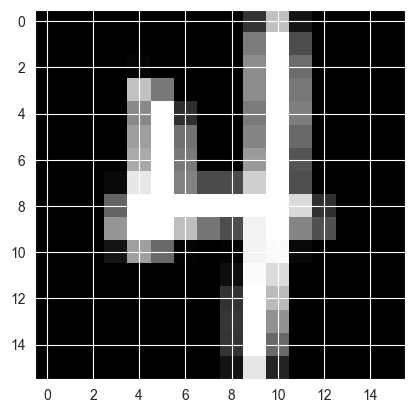



0.0


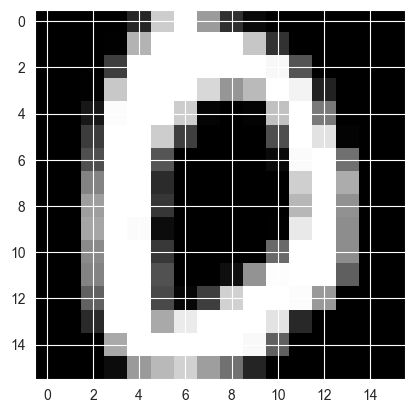

In [28]:
hard_points_labels = []
hard_points = []

for digit_index in np.argsort(mistakes)[-5:]:
    label = data[digit_index][0]
    point = data[digit_index][1:]
    print(label)
    display_digit(point)
    print('\n')